# Tutorial 1 - Dynamic Time Warping Proximity Analysis (DTW-PA)

**Dynamic Time Warping Proximity Analysis (DTW-PA)** is a procedure developed to provide a qualitative assessment of the suitability of the initial or current model for mitigating cycle-skipping in Full-Waveform Inversion (FWI). This analysis helps evaluate whether the model is well-positioned to achieve reliable inversion results.

The method is described in detail in the paper **Full-waveform inversion cycle-skipping mitigation with dynamic time warping, 
Part 1: a method for a proximity analysis between the current and the observed** (reference to be provided soon). We strongly recommend reading the paper to gain a full understanding of the methodology before proceeding with this tutorial.

This tutorial demonstrates how td use the DTW-PA code within the FWI framework of your choice, enabling you to apply this analysis to support your inversion objectives.

## Imports
First, we need to import the external and internal modules.

In [1]:
# =======================================================================
# Imports
# =======================================================================
import numpy as np
# =======================================================================

# =======================================================================
# Our Imports
# =======================================================================
from modules.utils import src_cs_dt, get_windows
from modules.utils import sgs_dtw_best_paths_and_distances
from modules.utils import normalize_seismograms
from modules.plots import plot_xy, plot_src, plot_seismogram_as_matrix
from modules.plots import plot_seismogram, plot_dtw_connections
from modules.plots import plot_dt_histogram, plot_dt_amp_scatter
from modules.plots import plot_cs_seismogram
# =======================================================================

## Source, seismograms and time step

In this tutorial, we do not aim to perform seismic data modelling or inversion. Instead, we use the Camembert model data presented in the referenced paper as CAM DISTANT, filtered at 5 Hz for the first multiscale step. The data consist of a Ricker wavelet as the source and the initial and target (true) seismograms generated using [Devito](https://www.devitoproject.org). Although the data represents objects in Devito, we convert them into `numpy.ndarray` for our purposes.

The target seismograms were generated using a 15 Hz Ricker wavelet and filtered with a second-order Butterworth band-pass filter ranging from 4.0 Hz to 25.0 Hz, simulating the absence of signals outside this frequency range. Subsequently, the seismograms were filtered with a 5 Hz low-pass filter for the first multiscale step.

The initial seismograms were obtained from the 15 Hz Ricker wavelet after applying, to the wavelet, the same frequency filters described above.

The time step information is also a necessary input for DTW-PA.

In the figure below, image (a) shows the target P-wave velocity model, while image (b) displays the initial model. The 33 red stars mark the source positions, and the 65 yellow triangles indicate the receiver locations.

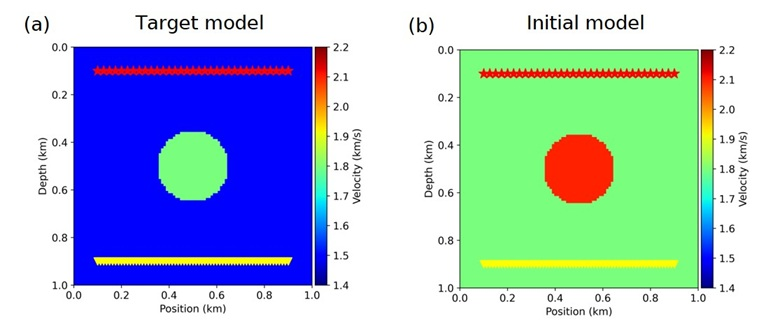

The central question we address here is: *is the initial model sufficiently close to the target model to avoid cycle-skipping*?

In [2]:
source = np.load(
    'data_example/source_bpf_lpf_5Hz.npy')
seismograms_initial = np.load(
    'data_example/seismogram_initial_bpf_lpf_5Hz.npy')
seismograms_true = np.load(
    'data_example/seismogram_true_bpf_lpf_5Hz.npy')

dt = 2.293  # Time step in [ms]

print(
    f'Seismogram shape is: {seismograms_true.shape},'
    'that is (number of shots, number of receivers, data).')
print(
    f'Source shape is: {source.shape},'
    'that is, only the source wavelet.')

print(f'The time step is: {dt} ms,')

Seismogram shape is: (33, 65, 1092),that is (number of shots, number of receivers, data).
Source shape is: (1092,),that is, only the source wavelet.
The time step is: 2.293 ms,


# Shot and receiver number

In the following examples, we present the data from the **shot number 0 (the first shot)** and **receiver number 0 (the first receiver)**. Of course, you can change it if you want.

In [3]:
shot_number = 0
receiver_number = 0

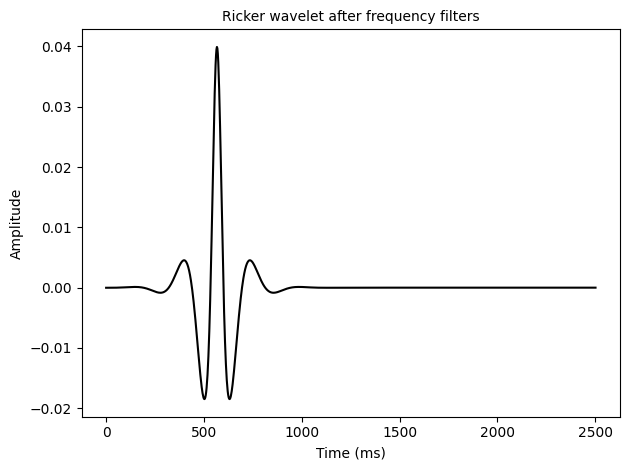

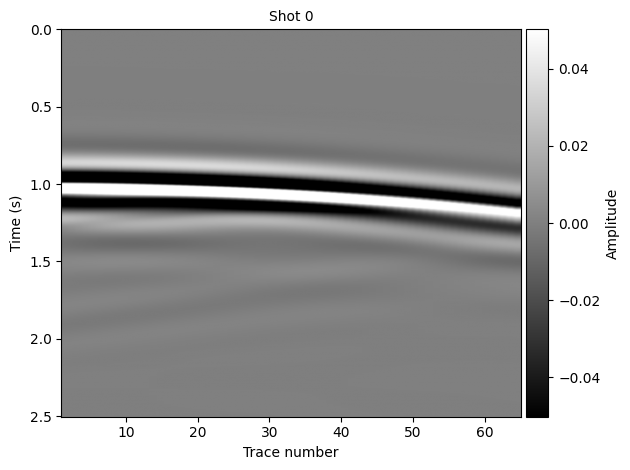

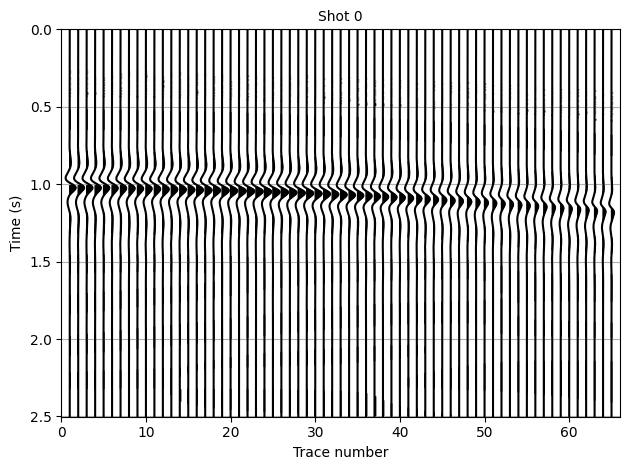

In [4]:
plot_src(
    src=source, dt=dt, title='Ricker wavelet after frequency filters')
plot_seismogram_as_matrix(
    seismograms=seismograms_initial,
    dt=dt,
    shot_num=shot_number,
    pseudo_gain=4,
    title=f'Shot {shot_number}')
plot_seismogram(
    seismograms=seismograms_initial,
    dt=dt,
    shot_num=shot_number,
    gain=4,
    title=f'Shot {shot_number}')

## Critical distance ($\Delta t_{cs}$) to mitigate cycle-skipping

To determine whether the initial model is sufficiently close to the target to mitigate cycle-skipping, it is crucial to define a critical time distance between the initial/current data and the target. The standard approach estimates $\Delta t_{cs} \approx 0.5 \cdot T_{peak}$​, where $T_{peak}$​ represents the peak period at each multiscale step. This can be computed using the `freq_cs_dt` function. However, we employ a more conservative method, calculating $\Delta t_{cs}$ (`dt_cs`) based on the objective value derived from the phase shift between two identical Ricker wavelets used as the source, where $\Delta t{cs}$ is the time difference between the global minimum and the nearest local maximum. Details are provided in the paper.

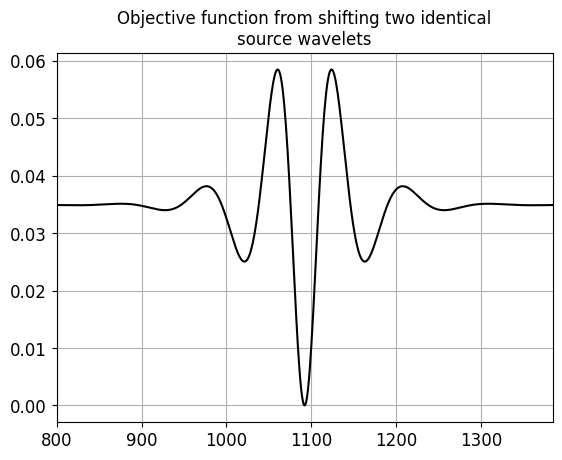

In [5]:
dt_cs, objective_function, min_index, max_index = \
    src_cs_dt(src=source, dt=dt)
# dt_cs = abs(min_index-max_index)*dt

plot_xy(
    y=objective_function,
    title='Objective function from shifting two identical\nsource wavelets',
    xlimit=(800, 1384))

## Analysis windows

Rather than analyzing the entire signal, you can focus on a window that contains key information about the velocity model. To define these analysis windows, it is necessary to specify a cutoff amplitude (`win_cutoff_amp`) and a pre/post-event time (`win_ppet`). The signal is examined in both forward and reverse time directions. When the first value exceeding the cutoff amplitude is detected, the window boundaries are adjusted by regressing the pre/post-event time, defining the start and end of the window.

In [6]:
win_cutoff_amp = 0.001
win_ppet = 20

windows = get_windows(
    seismograms_target=seismograms_true,
    seismograms_curr=seismograms_initial,
    cutoff_amp=win_cutoff_amp,
    ppet=win_ppet)

## Dynamic Time Warping (DTW) optimal path

It is now time to determine the optimal point-by-point relationships between each pair of signals (initial/current and target) in the seismogram set. This is achieved using the Dynamic Time Warping (DTW) method, implemented via the `sgs_dtw_best_paths_and_distances` function. Details about the function's outputs can be found in its documentation.

In [7]:
dtw_best_paths, dtw_short_best_paths, dtw_distances, sgs_distance = \
    sgs_dtw_best_paths_and_distances(
        seismograms_target=seismograms_true,
        seismograms_curr=seismograms_initial,
        windows=windows)

An example of the relationships found between a pair of signals is presented below. The connections are displayed in black when $\Delta t < \Delta t_{cs}$ and in red when $\Delta t \geq \Delta t_{cs}$.

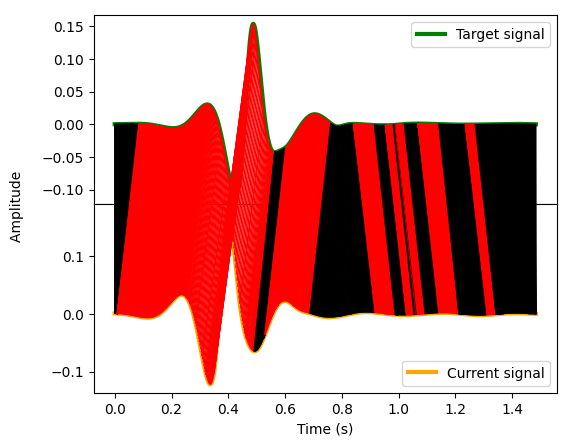

In [8]:
plot_dtw_connections(
    seismograms_target=seismograms_true,
    seismograms_curr=seismograms_initial,
    dt=dt,
    dt_cs=dt_cs,
    best_path=dtw_short_best_paths,
    shot_num=shot_number,
    rec_num=receiver_number,
    windows=windows,
    xlimit=None)

## Dynamic Time Warping Proximity Analysis (DTW-PA)

Finally, it is time to apply DTW-PA and address the question: *is the initial model sufficiently close to the target model to avoid cycle-skipping*?

DTW-PA involves analyzing three graphs. The first is a cumulative frequency histogram that indicates the proportion of data with $\Delta t < \Delta t_{cs}$. In the example below, only 24.94% of the data satisfies this condition. This serves as an initial indication that the initial model is not suitable for performing FWI while mitigating cycle-skipping, at least not solely using the multiscale approach.

The graph shown below is Figure 7f of the paper.

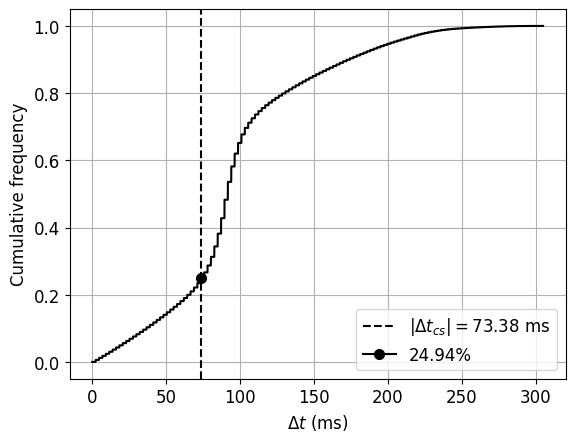

In [9]:
plot_dt_histogram(
    dt=dt,
    dt_cs=dt_cs,
    best_path=dtw_short_best_paths)

The second graph is a scatter plot showing the amplitude and $\Delta t$ associated with each signal point. To mitigate cycle-skipping, the points should ideally remain within the range $-\Delta t_{cs}$ and $\Delta t_{cs}$ as much as possible. Once again we have an indication that the initial model is not appropriate.

The graph shown below is Figure 7e of the paper.

D:\OneDrive\Documentos\Git\pessoal\dtw-pa-isa\teste\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


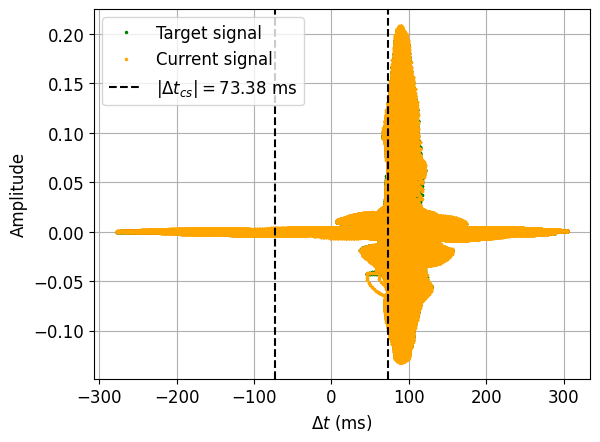

In [10]:
plot_dt_amp_scatter(
    seismograms_target=seismograms_true,
    seismograms_curr=seismograms_initial,
    dt=dt,
    dt_cs=dt_cs,
    best_path=dtw_short_best_paths,
    windows=windows)

The third and final graph is a seismogram with red markers highlighting sections likely to cause cycle-skipping, that is, with $\Delta t \geq \Delta t_{cs}$. As shown, a significant portion of the seismogram exhibits this behavior.

The graph shown below is Figure 7d of the paper.

The seismograms are normalized for visual purposes only.

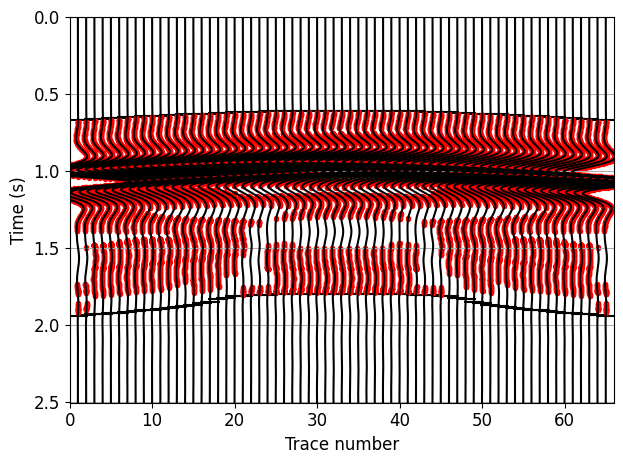

In [11]:
shot_number = 16

seismograms_true_norm = normalize_seismograms(
    seismograms= seismograms_true)
seismograms_initial_norm = normalize_seismograms(
    seismograms=seismograms_initial)

plot_cs_seismogram(
    seismograms_target=seismograms_true_norm,
    seismograms_curr=seismograms_initial_norm,
    dt=dt,
    dt_cs=dt_cs,
    best_path=dtw_short_best_paths,
    shot_num=shot_number,
    windows=windows,
    seismogram_to_plot='curr')

## Conclusion

As presented in the papaer, the initial model is not suitable for use in FWI when the multiscale approach is the sole method for mitigating cycle-skipping.

## License

This project is licensed under the GNU General Public License v3.0 - see the [LICENSE](./LICENSE) file for more details.